# LLM-Check: Investigating Detection of Hallucinations in Large Language Models
#### Members' Names: Partha Sai Aurangabadkar (501339009), Sai Seena Pulluru (501338745)

####  Emails: partha.aurangabadkar@torontomu.ca, saiseena.pulluru@torontomu.ca

# Introduction:

#### Problem Description:



#### Context of the Problem:

Large Language Models (LLMs)—like GPT-3, GPT-4, LLaMA, or Vicuna—are powerful tools. They can write stories, explain math problems, summarize documents, and more. But there’s a catch: sometimes, they generate content that sounds accurate but is actually false. These errors are called hallucinations. For example, an LLM might say that "Einstein won the Nobel Prize for the theory of relativity," when in fact, he won it for the photoelectric effect. The sentence sounds legit, but it’s factually wrong.

These hallucinations pose serious risks—imagine using LLMs for legal advice, scientific reporting, or health information. So, researchers have been working on ways to detect when an LLM is hallucinating. However, many of the existing methods are not practical. They require the model to generate many outputs for the same prompt (for example, 10 or 20 responses) or to look up facts in external knowledge bases. That’s not scalable or fast.

This paper asks a powerful question: can we detect hallucinations using just a single output from the LLM, without access to external tools or having to generate multiple responses? And can we do this in both white-box settings (where we have access to the model’s internals) and black-box settings (where we don’t)?


#### Limitation About other Approaches:
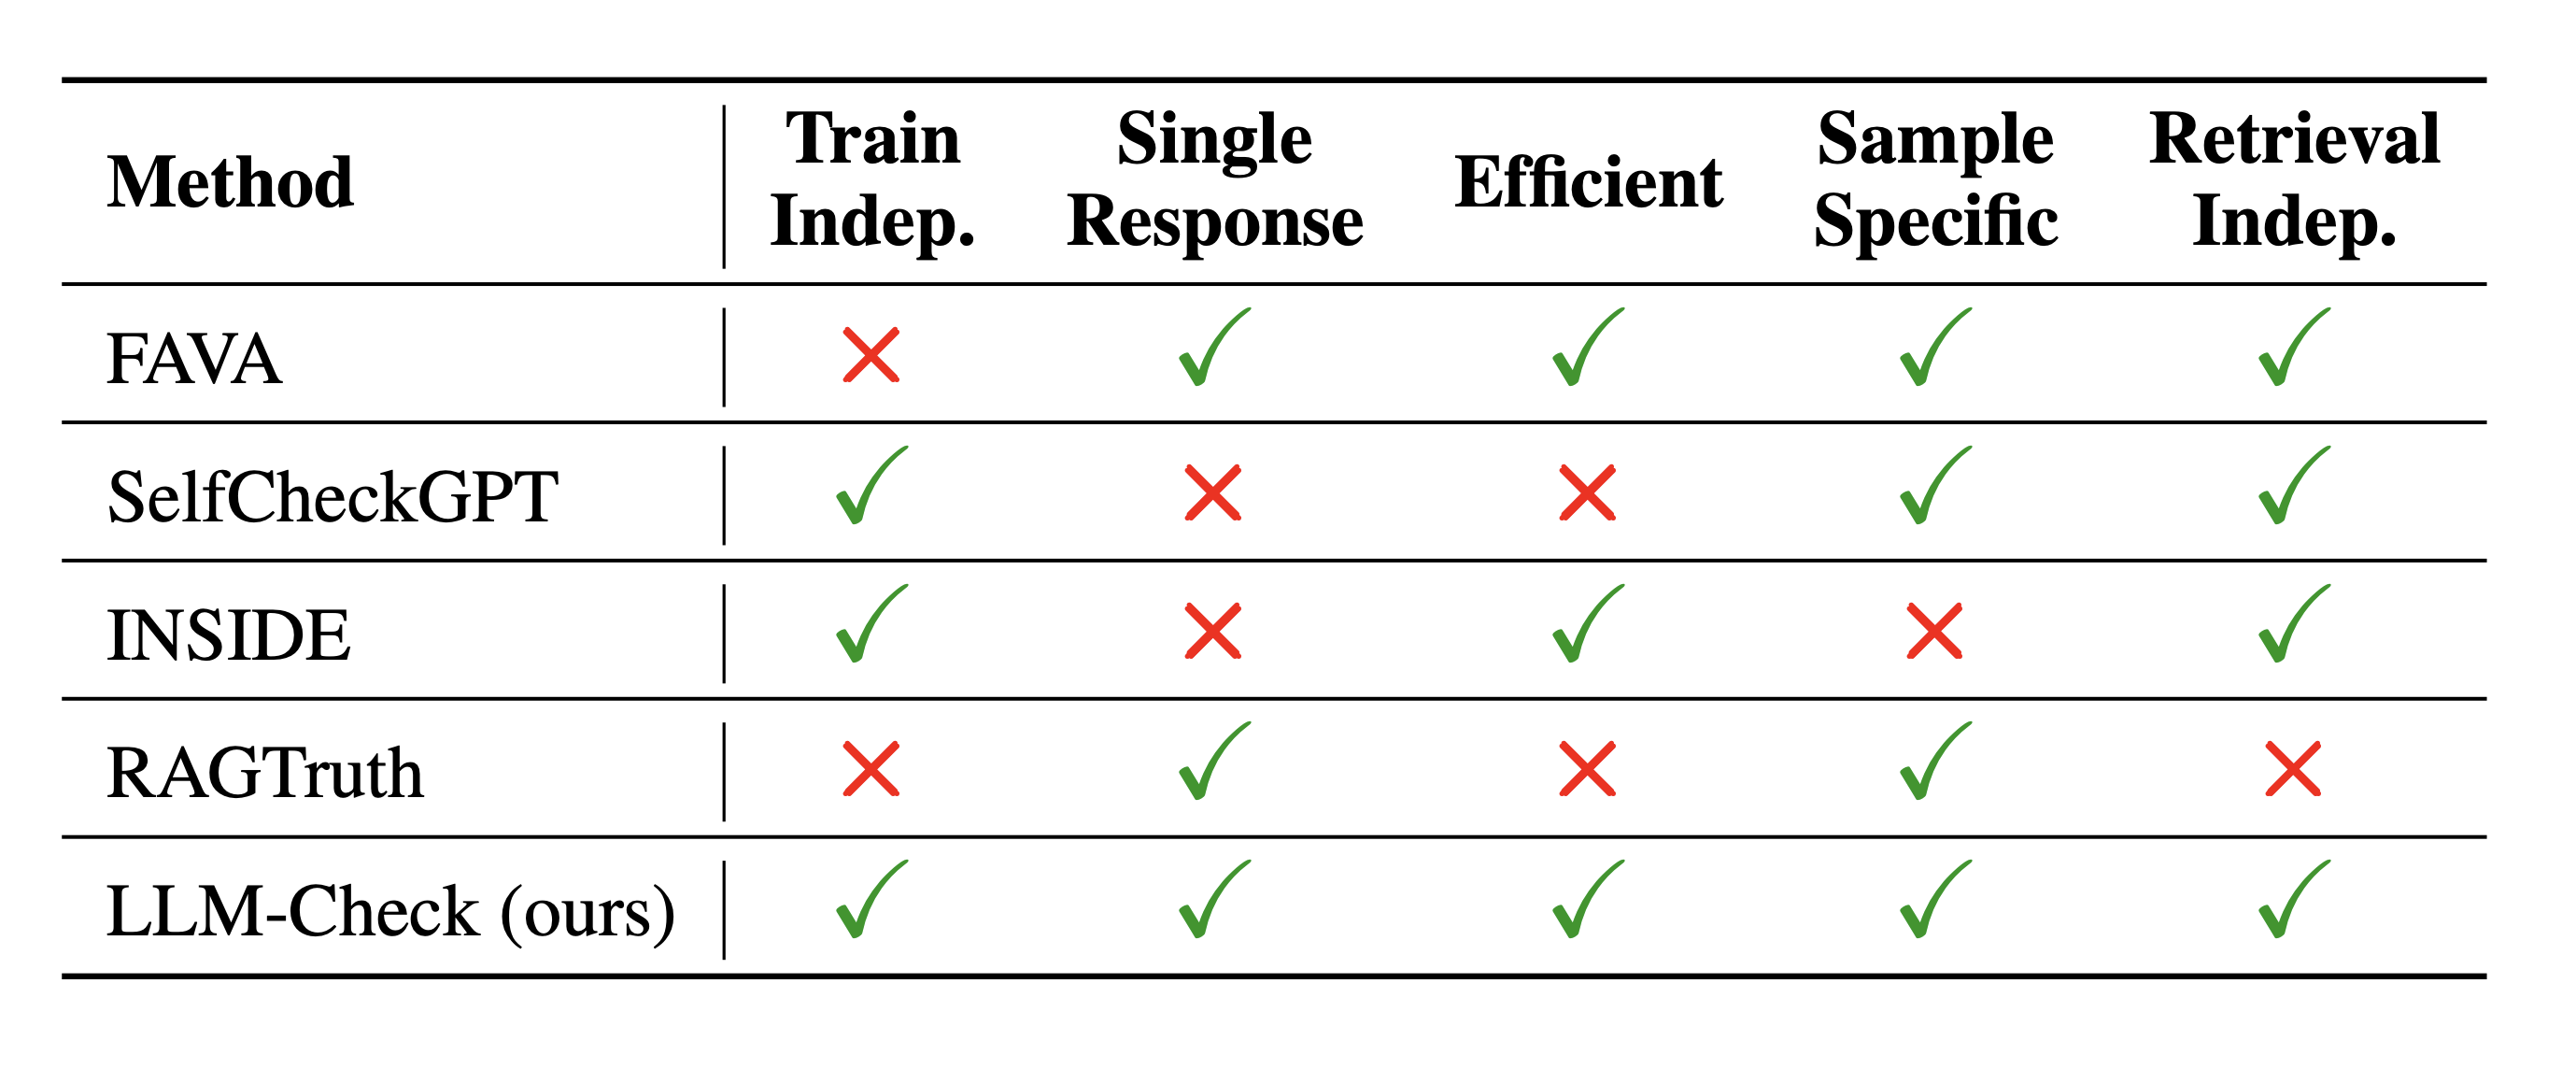

Prior approaches to hallucination detection, such as SelfCheckGPT and INSIDE, are limited by their heavy reliance on multiple model responses, external knowledge sources, or fine-tuned detectors, which makes them computationally expensive, slow, and impractical for real-time or large-scale applications. Additionally, their effectiveness often depends on specific model access or human-annotated data, reducing generalizability across different use cases.

•	SelfCheckGPT: Checks consistency across multiple generations but requires black-box access and is slow.

•	INSIDE: Uses eigenvalue analysis of hidden states across multiple outputs—detects hallucinations at a population level.

•	FAVA: A benchmark dataset for hallucinations with annotated samples.

•	RAGTruth: Focuses on hallucinations in outputs where external references are available.



#### Solution:

So we propose LLM-Check, a method that relies only on information generated during a single run of the LLM. Instead of relying on external data or multiple generations, LLM-Check looks into the internal behavior of the LLM itself—specifically, its hidden layer activations, attention patterns, and output probabilities.It works in both white-box (full access) and black-box (limited access) environments and even in RAG (Retrieval-Augmented Generation) settings. LLM-Check outperforms prior methods and is significantly faster—up to 450x speedup.

Imagine the LLM as a deep neural network where tokens go in, pass through a series of transformations, and then the next token is predicted. What LLM-Check does is analyze how the model processes this input and output internally. It's like watching a person’s body language and eye movement to see if they’re lying—instead of asking them the same question 20 times.


# Background



| Reference |Explanation |  Dataset/Input |Weakness
| --- | --- | --- | --- |
| SelfCheckGPT [Manakul et al., 2023] | Used multiple generations of an LLM and measured response consistency across those samples to detect hallucinations.| SelfCheckGPT Dataset (GPT-3 responses) | Requires multiple outputs and is computationally expensive; less effective at passage level.
| INSIDE [Chen et al., 2024]         | Analyzed the self-consistency of hidden states across multiple generations by computing eigenvalue decompositions.        | GPT-3 multi-response samples (augmented FAVA) | Requires multiple outputs; only detects hallucination at a population level.                   |
| Azaria and Mitchell [2023]         | Trained a feedforward neural network on hidden activations to classify truthfulness of short sentences.                   | True/False sentence dataset                   | Needs labeled data and supervised training; does not scale to longer text or black-box models. |
| Wu et al. [2023]                   | Created RAGTruth and fine-tuned LLMs on span-level hallucination annotations in retrieved documents.                      | RAGTruth Dataset                              | Requires fine-tuning; high annotation and computational overhead.                              |
| Mishra et al. [2024]               | Released FAVA benchmark and fine-tuned LLaMA-2 on synthetic and annotated hallucination samples.                          | FAVA (Synthetic + Annotated)                  | Requires training and labeled data; not suited for zero-shot or black-box use cases.           |
| LLM-Check (Ours)                   | Detects hallucinations from a single LLM response using internal states, attention patterns, and logit uncertainty scores.| FAVA, SelfCheckGPT, RAGTruth                  | No retraining needed, but future work aims to improve TPR at low FPR and handle edge cases.    |




# Methodology



In this work, we propose to directly analyze the variations in model characteristics between truthful and hallucinated examples by examining the rich semantic representations present in internal LLM representations, since we observe that the LLM can often generate the truthful version, albeit with potentially lower frequency. For instance, we observe that the kernel similarity map of self-attention across different tokens can be sensitive to Truthful or Hallucinated tokens!

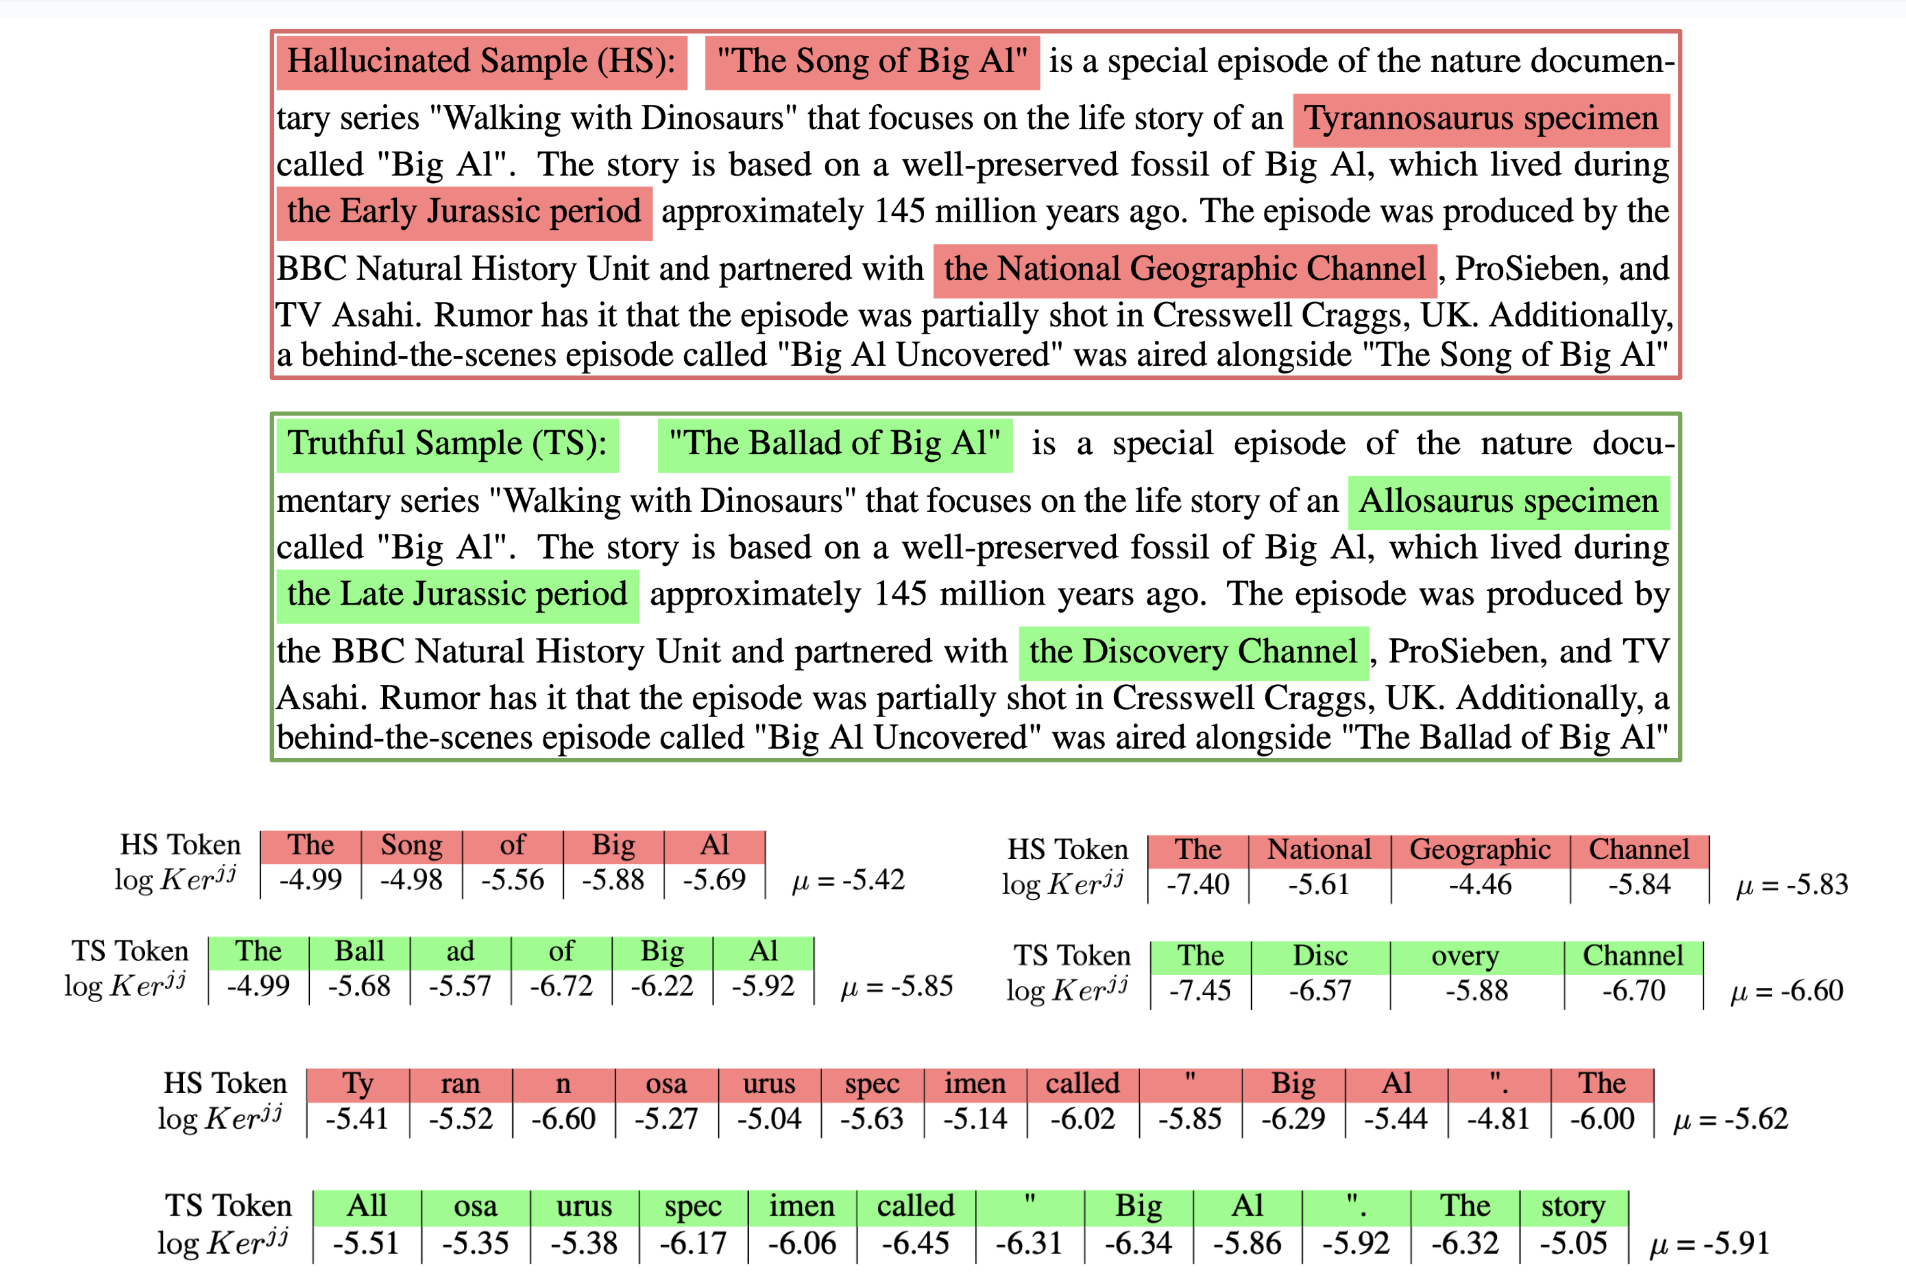

<b>What Does LLM-Check Look At Inside the Model?</b>

There are two main internal signals the paper analyzes:

<b>1.	Hidden State Representations:</b>

Every token that the model generates gets turned into a high-dimensional vector inside the network. These vectors change at each layer of the network, and these changes capture how the model interprets the meaning of the token in context. LLM-Check calculates something called the log-determinant of the covariance matrix of these hidden states. If hallucinations are present, this value behaves differently—indicating instability or inconsistency in how the model processed the response.

<b>2.	Attention Maps:</b>

The attention mechanism in a transformer model tells you what part of the text the model is "looking at" when predicting each token. The authors compute the diagonal eigenvalues of the self-attention matrices and analyze their mean log-determinants. These values also shift when the model is generating hallucinated vs. truthful content.

Together, these two signals form a kind of semantic fingerprint of the generation. The hypothesis is that hallucinated responses will have structural differences in these internal metrics compared to truthful ones, even if the response is only generated once.

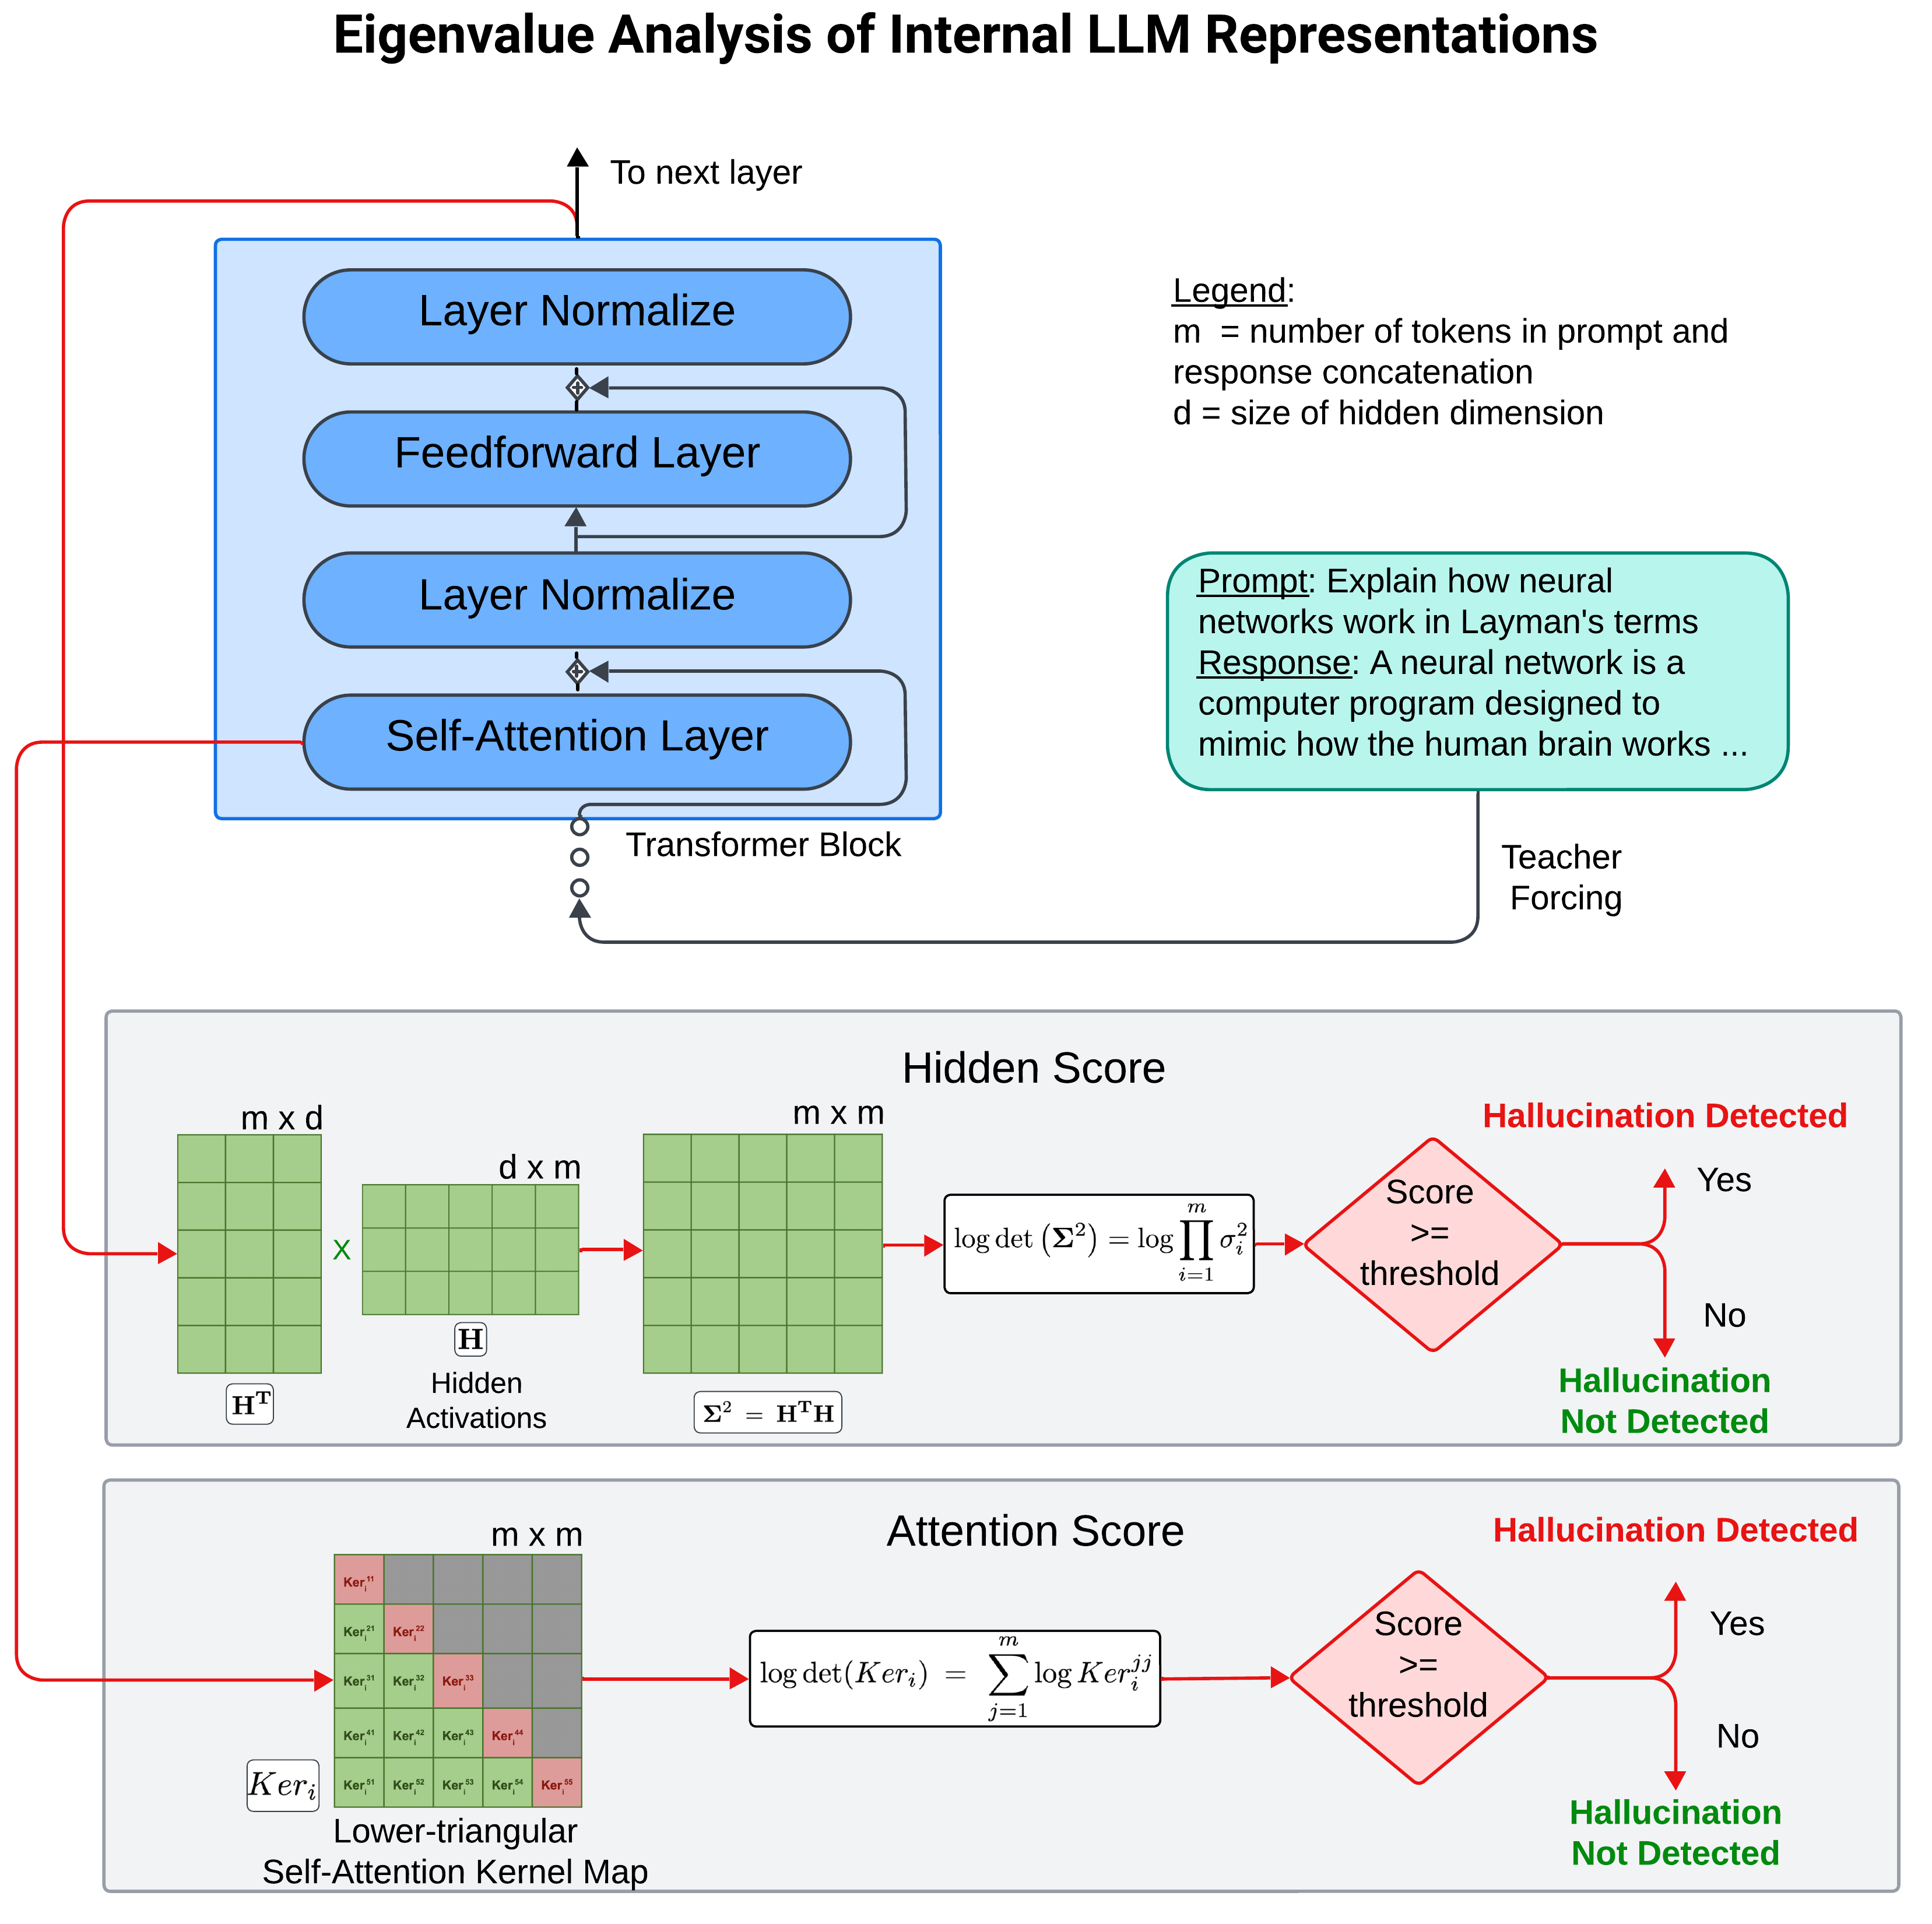

<b>They Don’t Stop There: Output Token Analysis</b>

Beyond the internal layers, the researchers also look at the final probabilities assigned to output tokens.

•	They calculate <b>perplexity</b>, which measures how confident the model was about the words it generated. 

High perplexity = less confidence = more likely hallucination.

•	They calculate <b>logit entropy</b>, a measure of uncertainty in the model's prediction at each step. 

Higher entropy = model is unsure = suspicious.

•	Finally, they improve this by using <b>windowed logit entropy</b>, where they analyze local parts of the sentence. Sometimes, only one sentence in a paragraph is hallucinated. Windowed entropy helps detect such partial hallucinations better than averaging across the whole output.

This dual analysis—of the inner neural network signals and final output probability signals—makes LLM-Check a powerful, fast hallucination detector.



<b>Taxonomy of Hallucination Detection</b>

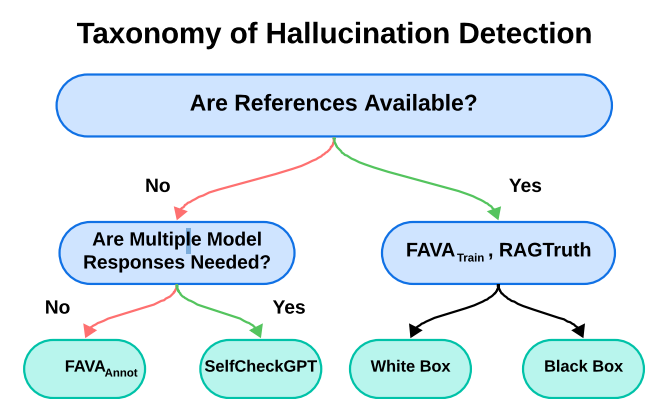

LLM-Check was tested across several types of setups, which are organized into a taxonomy:

•	Without External References: Here, they evaluate using:

- A single model response (realistic for most users).
- Multiple model responses (like SelfCheckGPT, for comparison).

•	With External References (like Wikipedia or source documents):
- In white-box settings, they have full access to the original model's internals.
- In black-box settings, they use a substitute model (like LLaMA) and analyze it using teacher forcing—this means forcing the substitute model to reproduce the same output so that we can look at its internals.




Three major <b>datasets</b> have been used:

1.	FAVA – Human-annotated examples of hallucinations.
2.	SelfCheckGPT – Sentences with many responses for consistency analysis.
3.	RAGTruth – Hallucinations in Retrieval-Augmented Generation (RAG) settings, with external source documents.


<b>Models Tested</b>:

•	LLaMA-2 (7B, 13B, 70B)

•	LLaMA-3-8B

•	Vicuna (7B, 13B)

•	Pythia-7B

•	Guanaco

•	Falcon-7B

•	Mistral-7B

<b>Metrics Used:</b>

•	Accuracy

•	AUROC (how well hallucinations are distinguished)

•	F1 Score

•	TPR @ 5% FPR

•	Runtime per sample


When we compare the overall runtime cost of the proposed detection scores with other baselines using a Llama-2-7b Chat model on the FAVA-Annotation dataset on a single Nvidia A5000 GPU,for the Eigen Analysis based methods, we report the total time needed for all 32 Layers for Attention and Hidden Scores. We observe that the Logit and Attention scores are indeed very efficient, while the Hidden Score is slightly slower since it uses SVD explicitly. We also observe that LLM-Check is considerably faster than most baselines with speedups of up to 45x and 450x, since it only uses model representations with teacher forcing, without additional inference time overheads.

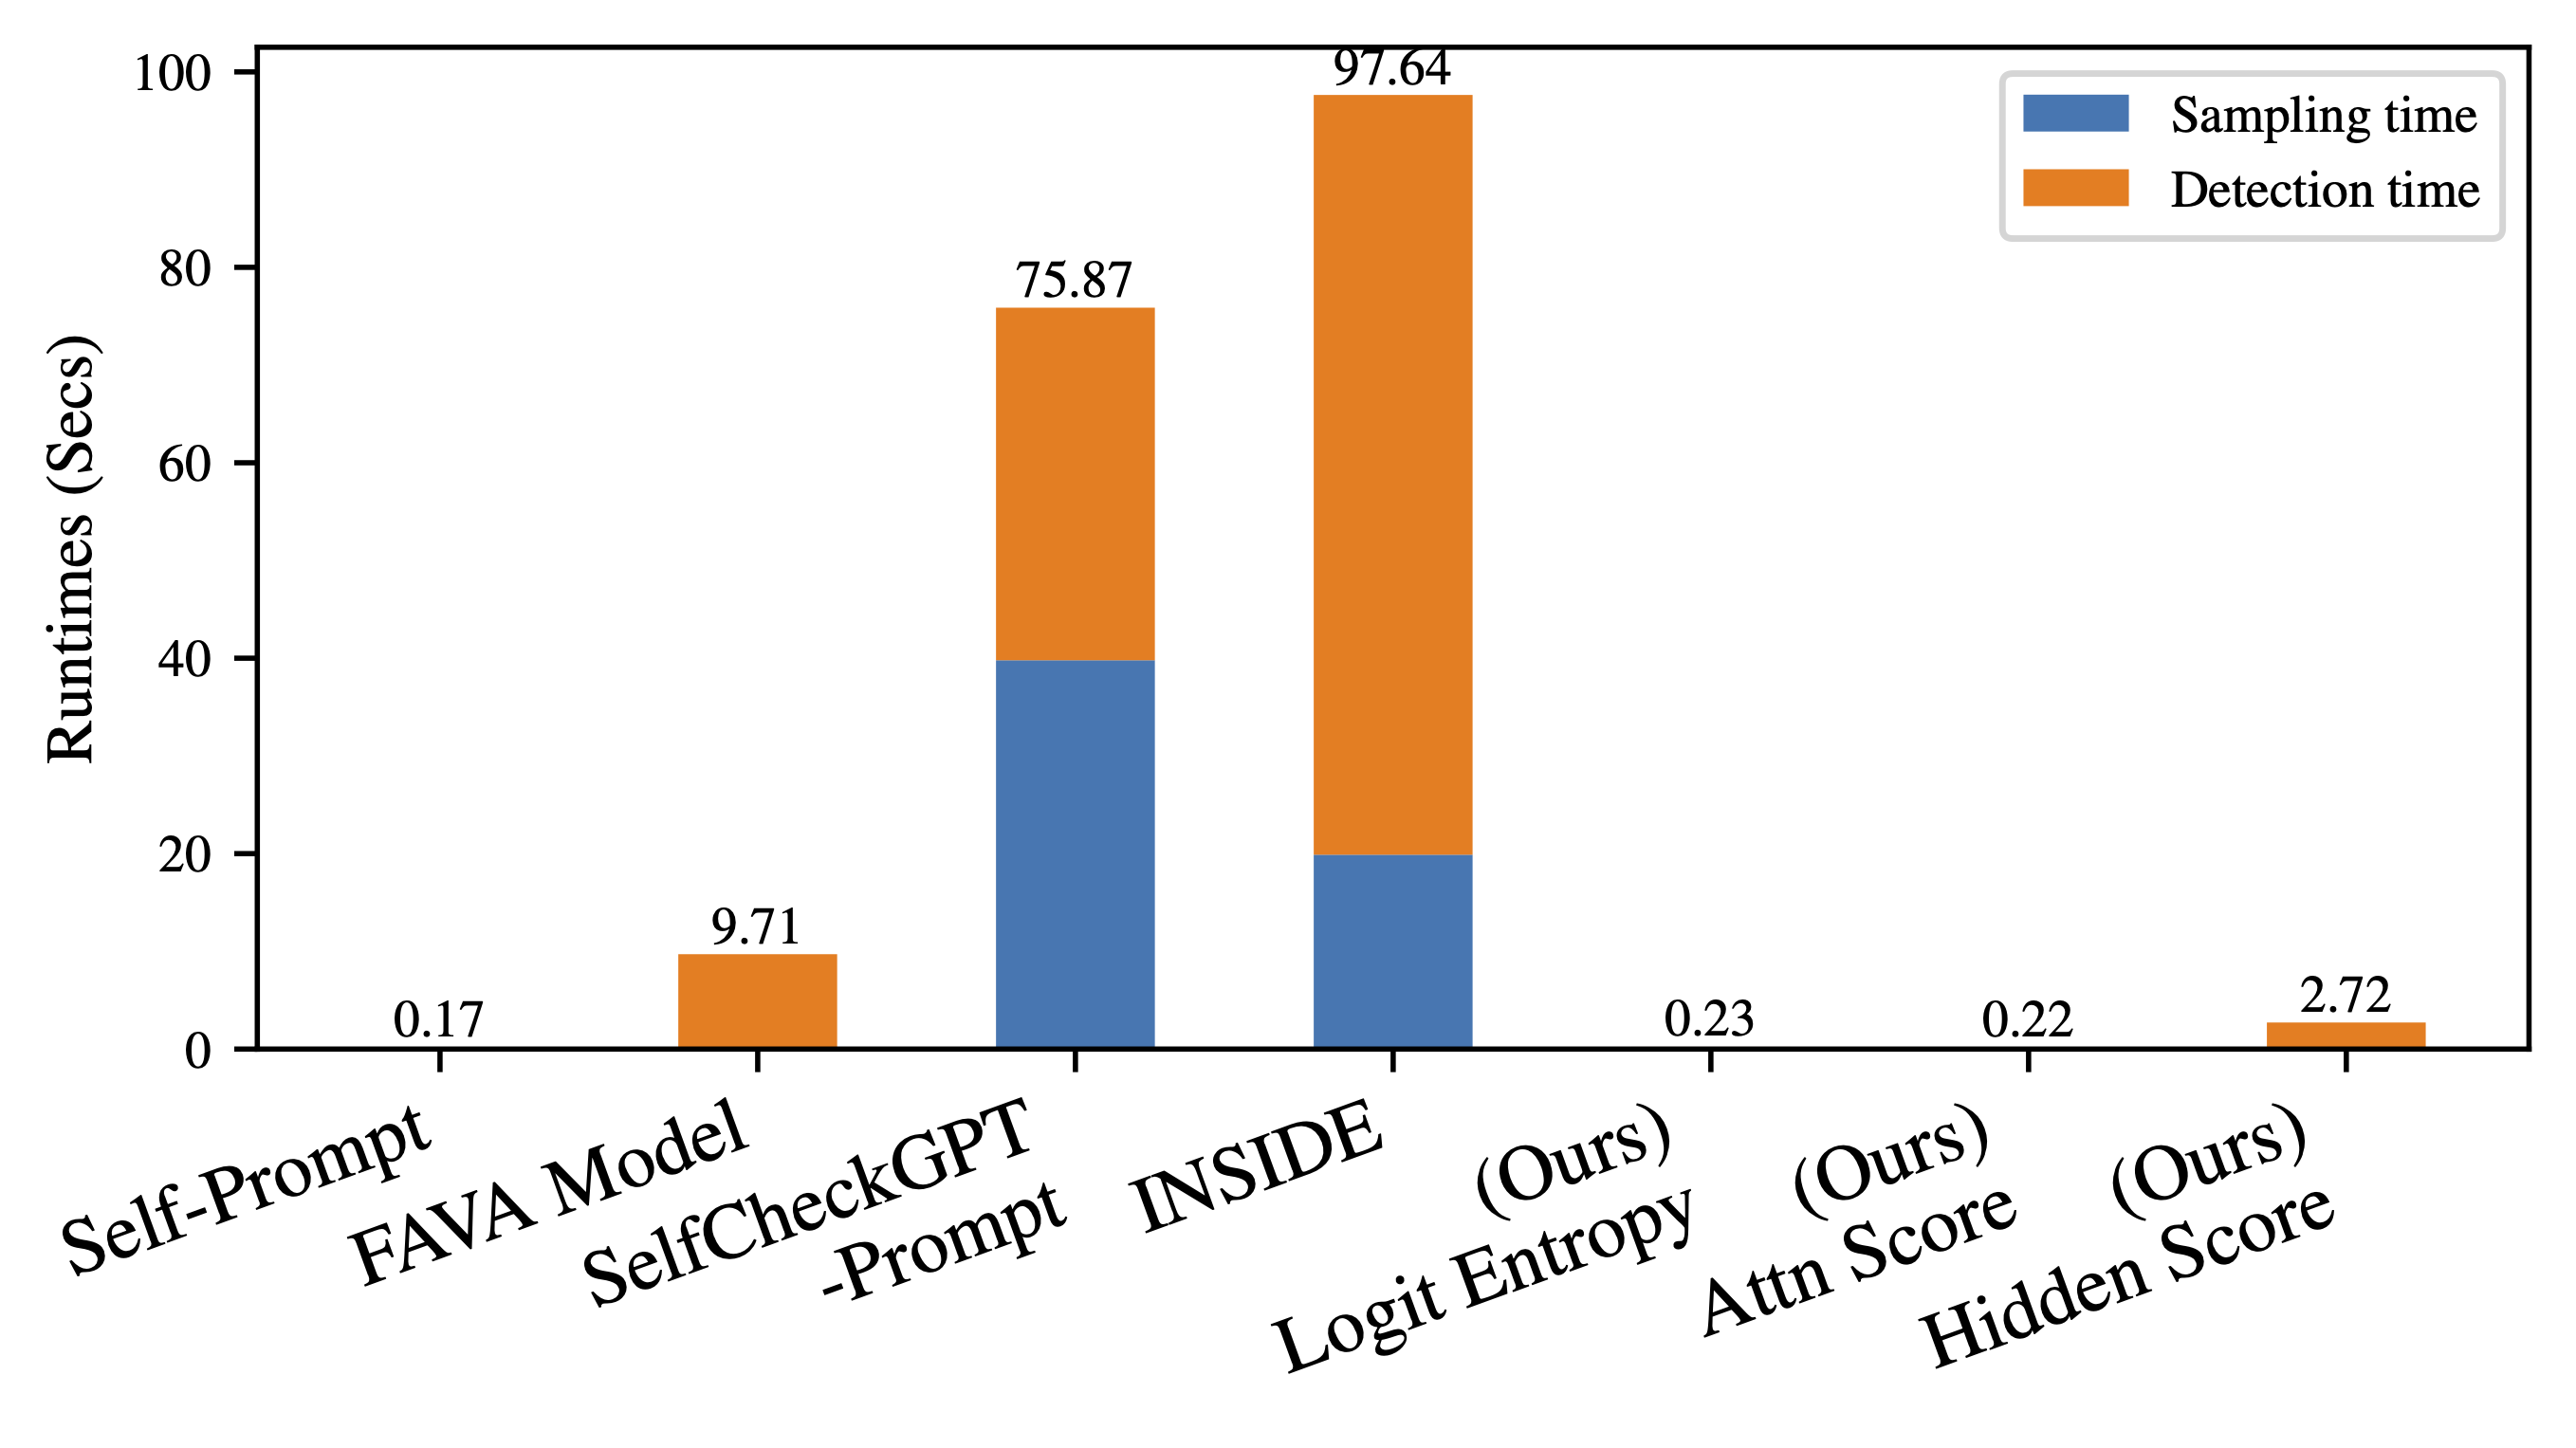


# Implementation



In [2]:
import numpy as np
import torch
from sklearn.metrics import auc, roc_curve
from transformers import AutoModelForCausalLM, AutoTokenizer


def load_dataset_utils(args):
    """Util to lead different datasets"""
    if args.dataset == "selfcheck":
        import utils_selfcheck

        get_data = utils_selfcheck.get_selfcheck_data
        get_scores_dict = utils_selfcheck.get_scores_dict
    elif args.dataset == "fava":
        import utils_fava

        get_data = utils_fava.get_fava_data
        get_scores_dict = utils_fava.get_scores_dict
    elif args.dataset == "fava_annot":
        import utils_fava_annotated

        get_data = utils_fava_annotated.get_fava_data
        get_scores_dict = utils_fava_annotated.get_scores_dict
    elif args.dataset == "rag_truth":
        import utils_ragtruth

        get_data = utils_ragtruth.get_ragtruth_data
        get_scores_dict = utils_ragtruth.get_scores_dict
    else:
        raise ValueError("Invalid dataset")
    return get_data, get_scores_dict


def get_roc_scores(scores: np.array, labels: np.array):
    """
    Util to get area under the curve, accuracy and tpr at 5% fpr
    Args:
        scores (np.array): Scores for the prediction
        labels (np.array): Ground Truth Labels

    Returns:
        arc (float): area under the curve
        accuracy (float): accuracy at best TPR and FPR selection
        low (float): TPR at 5% FPR
    """
    fpr, tpr, _ = roc_curve(labels, scores)
    arc = auc(fpr, tpr)
    acc = np.max(1 - (fpr + (1 - tpr)) / 2)
    low = tpr[np.where(fpr < 0.05)[0][-1]]
    return arc, acc, low


def get_roc_auc_scores(scores: np.array, labels: np.array):
    """
    Util to get area under the curve, accuracy and tpr at 5% fpr
    Args:
        scores (np.array): Scores for the prediction
        labels (np.array): Ground Truth Labels

    Returns:
        arc (float): area under the curve
        accuracy (float): accuracy at best TPR and FPR selection
        low (float): TPR at 5% FPR
        fpr (np.array): Array with False Positive Values
        tpr (np.array): Array with True Positive Values
    """
    fpr, tpr, _ = roc_curve(labels, scores)
    arc = auc(fpr, tpr)
    acc = np.max(1 - (fpr + (1 - tpr)) / 2)
    low = tpr[np.where(fpr < 0.05)[0][-1]]
    return arc, acc, low, fpr, tpr


def get_full_model_name(model_name: str):
    """Map a short model name identifier to a fully qualified model name"""
    if "vicuna7b" in model_name:
        name = ["vicuna", "lmsys/vicuna-7b-v1.5"]
    elif "vicuna13b" in model_name:
        name = ["vicuna13b", "lmsys/vicuna-13b-v1.5"]
    elif "llama-3" in model_name:
        name = ["llama-3", "meta-llama/Meta-Llama-3-8B-Instruct"]
    elif "llama" in model_name:
        name = ["llama", "meta-llama/Llama-2-7b-chat-hf"]
    elif "pythia" in model_name:
        name = ["pythia", "togethercomputer/Pythia-Chat-Base-7B"]
    elif "guanaco" in model_name:
        name = ["guanaco", "JosephusCheung/Guanaco"]
    elif "mistral" in model_name:
        name = ["mistral", "mistralai/Mistral-7B-Instruct-v0.2"]
    elif "falcon" in model_name:
        name = ["falcon", "tiiuae/falcon-7b-instruct"]
    return name


def load_model_and_tokenizer(
    model_name_or_path: str, tokenizer_name_or_path: str = None, dtype=torch.float16, **kwargs
):
    """Util to load model and tokenizer"""
    model = AutoModelForCausalLM.from_pretrained(model_name_or_path, device_map="auto", torch_dtype=dtype, **kwargs)
    model.requires_grad_(False)
    if model.generation_config.temperature is None:
        model.generation_config.temperature = 1.0
    model.generation_config.do_sample = True

    tokenizer_name_or_path = model_name_or_path if tokenizer_name_or_path is None else tokenizer_name_or_path
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name_or_path)
    tokenizer.padding_side = "left"
    if tokenizer.pad_token is None:
        tokenizer.pad_token = "[PAD]"

    return model, tokenizer


def compute_scores(logits, hidden_acts, attns, scores, indiv_scores, mt_list, tok_ins, tok_lens, use_toklens=True):
    """Compute various evaluation scores (e.g., perplexity, entropy, SVD scores) from model outputs.

    This function takes model outputs (logits, hidden states, attentions) and computes
    a list of metric scores defined by `mt_list`. The computed scores are appended
    to `scores` and `indiv_scores` dictionaries for tracking.

    NOTE: The indiv_scores score dictionary will be saved to disk and then used for final metric computation in
    check scores ipynb

    Args:
        logits: Model logits.
        hidden_acts: Hidden activations.
        attns: Attention matrices.
        scores (list): A list to store aggregated scores across samples.
        indiv_scores (dict): A dictionary to store metric-specific scores for each sample
        mt_list (list): A list of metric types to compute.
        tok_ins: A list of tokenized inputs for each sample.
        tok_lens: A list of tuples indicating the start and end token indices for each sample.
        use_toklens (bool, optional): Whether to use `tok_lens` to slice sequences. Defaults to True.

    Raises:
        ValueError: If an invalid metric type is encountered in `mt_list`.
    """
    sample_scores = []
    for mt in mt_list:
        mt_score = []
        if mt == "logit":
            mt_score.append(perplexity(logits, tok_ins, tok_lens)[0])
            indiv_scores[mt]["perplexity"].append(mt_score[-1])

            mt_score.append(window_logit_entropy(logits, tok_lens, w=1)[0])
            indiv_scores[mt]["window_entropy"].append(mt_score[-1])

            mt_score.append(logit_entropy(logits, tok_lens, top_k=50)[0])
            indiv_scores[mt]["logit_entropy"].append(mt_score[-1])

        elif mt == "hidden":
            for layer_num in range(1, len(hidden_acts[0])):
                mt_score.append(get_svd_eval(hidden_acts, layer_num, tok_lens, use_toklens)[0])
                indiv_scores[mt]["Hly" + str(layer_num)].append(mt_score[-1])

        elif mt == "attns":
            for layer_num in range(1, len(attns[0])):
                mt_score.append(get_attn_eig_prod(attns, layer_num, tok_lens, use_toklens)[0])
                indiv_scores[mt]["Attn" + str(layer_num)].append(mt_score[-1])

        else:
            raise ValueError("Invalid method type")

        sample_scores.extend(mt_score)

    scores.append(sample_scores)


def get_model_vals(model, tok_in):
    """Run the model forward pass to obtain logits, hidden states, and attention scores.

    Args:
        model: A pretrained model compatible with the transformers API.
        tok_in (torch.Tensor): A tensor of tokenized input IDs.

    Returns:
        tuple: A tuple `(logits, hidden_states, attentions)` where:
        logits (torch.Tensor): Output logits from the model.
        hidden_states (tuple of torch.Tensor): Hidden states from each model layer.
        attentions (tuple of torch.Tensor): Attention weights from each model layer.
    """
    kwargs = {
        "input_ids": tok_in,
        "use_cache": False,
        "past_key_values": None,
        "output_attentions": True,
        "output_hidden_states": True,
        "return_dict": True,
    }
    with torch.no_grad():
        output = model(**kwargs)
    return output.logits, output.hidden_states, output.attentions


def get_logits(model, tok_in):
    """Get only the logits from the model forward pass.

    Args:
        model: A pretrained model compatible with the transformers API.
        tok_in (torch.Tensor): A tensor of tokenized input IDs.

    Returns:
        torch.Tensor: The output logits of the model for the given input.
    """
    kwargs = {
        "input_ids": tok_in,
        "use_cache": False,
        "past_key_values": None,
        "output_attentions": True,
        "output_hidden_states": True,
        "return_dict": True,
    }
    output = model(**kwargs)
    return output.logits


def get_hidden_acts(model, tok_in):
    """Get hidden states (activations) from the model forward pass.

    Args:
        model: A pretrained model compatible with the transformers API.
        tok_in (torch.Tensor): A tensor of tokenized input IDs.

    Returns:
        tuple of torch.Tensor: The hidden states from each layer of the model.
    """
    kwargs = {
        "input_ids": tok_in,
        "use_cache": False,
        "past_key_values": None,
        "output_attentions": True,
        "output_hidden_states": True,
        "return_dict": True,
    }
    with torch.no_grad():
        output = model(**kwargs)
    return output.hidden_states


def get_attentions(model, tok_in):
    """Get attention matrices from the model forward pass.

    Args:
        model: A pretrained model compatible with the transformers API.
        tok_in (torch.Tensor): A tensor of tokenized input IDs.

    Returns:
        tuple of torch.Tensor: The attention matrices from each layer and head.
    """
    kwargs = {
        "input_ids": tok_in,
        "use_cache": False,
        "past_key_values": None,
        "output_attentions": True,
        "output_hidden_states": True,
        "return_dict": True,
    }
    with torch.no_grad():
        output = model(**kwargs)
    return output.attentions


def centered_svd_val(Z, alpha=0.001):
    """Compute the mean log singular value of a centered covariance matrix.

    This function centers the data and computes the singular value decomposition
    (SVD) of the resulting covariance matrix. It then returns the mean of the
    log singular values, regularized by `alpha`.

    Args:
        Z (torch.Tensor): A 2D tensor representing features hidden acts.
        alpha (float, optional): Regularization parameter added to the covariance matrix.
            Defaults to 0.001.

    Returns:
        float: The mean of the log singular values of the centered covariance matrix.
    """
    # assumes Z is in full precision
    J = torch.eye(Z.shape[0]) - (1 / Z.shape[0]) * torch.ones(Z.shape[0], Z.shape[0])
    Sigma = torch.matmul(torch.matmul(Z.t(), J), Z)
    Sigma = Sigma + alpha * torch.eye(Sigma.shape[0])
    svdvals = torch.linalg.svdvals(Sigma)
    eigscore = torch.log(svdvals).mean()
    return eigscore


def get_svd_eval(hidden_acts, layer_num=15, tok_lens=[], use_toklens=True):
    """Evaluate hidden states at a given layer using SVD-based scoring.

    For each sample, this function extracts the hidden states at a specified layer,
    optionally slices them according to `tok_lens`, and computes the SVD-based score.

    Args:
        hidden_acts (list): A list of tuples, each containing hidden states for all layers
            for a single sample.
        layer_num (int, optional): The layer index to evaluate. Defaults to 15.
        tok_lens (list, optional): A list of (start, end) indices for each sample to slice
            the hidden states. Defaults to [].
        use_toklens (bool, optional): Whether to slice the hidden states using `tok_lens`.
            Defaults to True.

    Returns:
        np.array: An array of SVD-based scores for each sample.
    """
    svd_scores = []
    for i in range(len(hidden_acts)):
        Z = hidden_acts[i][layer_num]

        if use_toklens and tok_lens[i]:
            i1, i2 = tok_lens[i][0], tok_lens[i][1]
            Z = Z[i1:i2, :]

        Z = torch.transpose(Z, 0, 1)
        svd_scores.append(centered_svd_val(Z).item())
    # print("Sigma matrix shape:",Z.shape[1])
    return np.stack(svd_scores)


def get_attn_eig_prod(attns, layer_num=15, tok_lens=[], use_toklens=True):
    """Compute an eigenvalue-based attention score by analyzing attention matrices.

    This function takes the attention matrices of a given layer and for each sample,
    computes the mean log of the diagonal elements (assumed to be eigenvalues) across
    all attention heads. Slices are applied if `tok_lens` is used.

    Args:
        attns (list): A list of tuples, each containing attention matrices for all layers
            and heads for a single sample.
        layer_num (int, optional): The layer index to evaluate. Defaults to 15.
        tok_lens (list, optional): A list of (start, end) indices for each sample to slice
            the attention matrices. Defaults to [].
        use_toklens (bool, optional): Whether to slice the attention matrices using `tok_lens`.
            Defaults to True.

    Returns:
        np.array: An array of computed attention-based eigenvalue scores for each sample.
    """
    attn_scores = []

    for i in range(len(attns)):  # iterating over number of samples
        eigscore = 0.0
        for attn_head_num in range(len(attns[i][layer_num])):  # iterating over number of attn heads
            # attns[i][layer_num][j] is of size seq_len x seq_len
            Sigma = attns[i][layer_num][attn_head_num]

            if use_toklens and tok_lens[i]:
                i1, i2 = tok_lens[i][0], tok_lens[i][1]
                Sigma = Sigma[i1:i2, i1:i2]

            eigscore += torch.log(torch.diagonal(Sigma, 0)).mean()
        attn_scores.append(eigscore.item())
    return np.stack(attn_scores)


def perplexity(logits, tok_ins, tok_lens, min_k=None):
    """Compute the perplexity of model predictions for given tokenized inputs.

    This function computes the perplexity by taking the negative log probability
    of the correct tokens and exponentiating the mean. If `min_k` is provided,
    it filters the lowest probabilities to compute a restricted perplexity.

    Args:
        logits: A list or array of model logits (samples x seq_len x vocab_size).
        tok_ins: A list of tokenized input IDs for each sample.
        tok_lens (list): A list of (start, end) indices specifying the portion of the
            sequence to evaluate.
        min_k (float, optional): A fraction of tokens to consider from the lowest
            probabilities. If not None, only these tokens are considered.

    Returns:
        np.array: An array of perplexity values for each sample.
    """
    softmax = torch.nn.Softmax(dim=-1)
    ppls = []

    for i in range(len(logits)):
        i1, i2 = tok_lens[i][0], tok_lens[i][1]
        pr = torch.log(softmax(logits[i]))[torch.arange(i1, i2) - 1, tok_ins[i][0, i1:i2]]
        if min_k is not None:
            pr = torch.topk(pr, k=int(min_k * len(pr)), largest=False).values
        ppls.append(torch.exp(-pr.mean()).item())

    return np.stack(ppls)


def logit_entropy(logits, tok_lens, top_k=None):
    """Compute the entropy of the model's output distribution over tokens.

    For each sample, this function computes the entropy of the softmax distribution
    over predicted tokens. If `top_k` is provided, only the top K predictions are considered
    when computing entropy.

    Args:
        logits: A list or array of model logits (samples x seq_len x vocab_size).
        tok_lens (list): A list of (start, end) indices specifying the portion of the
            sequence to evaluate.
        top_k (int, optional): Number of top tokens to consider for computing the entropy.
            If None, considers all tokens.

    Returns:
        np.array: An array of entropy values for each sample.
    """
    softmax = torch.nn.Softmax(dim=-1)
    scores = []

    for i in range(len(logits)):
        i1, i2 = tok_lens[i][0], tok_lens[i][1]
        if top_k is None:
            l = softmax(torch.tensor(logits[i]))[i1:i2]
            scores.append((-l * torch.log(l)).mean())
        else:
            l = logits[i][i1:i2]
            l = softmax(torch.topk(l, top_k, 1).values)
            scores.append((-l * torch.log(l)).mean())

    return np.stack(scores)


def window_logit_entropy(logits, tok_lens, top_k=None, w=1):
    """Compute the maximum average entropy in windows of tokens.

    This function computes the entropy as in `logit_entropy`, but applies a sliding window
    of width `w` over the token dimension and returns the maximum mean entropy found.

    Args:
        logits: A list or array of model logits (samples x seq_len x vocab_size).
        tok_lens (list): A list of (start, end) indices specifying the portion of the
            sequence to evaluate.
        top_k (int, optional): Number of top tokens to consider for computing the entropy.
            If None, considers all tokens.
        w (int, optional): Window size to compute local entropy. Defaults to 1.

    Returns:
        np.array: An array of maximum windowed entropy values for each sample.
    """
    softmax = torch.nn.Softmax(dim=-1)
    scores = []

    for i in range(len(logits)):
        i1, i2 = tok_lens[i][0], tok_lens[i][1]
        if top_k is None:
            l = softmax(logits[i])[i1:i2]
        else:
            l = torch.tensor(logits[i])[i1:i2]
            l = softmax(torch.topk(l, top_k, 1).values)
        windows = torch.max((-l * torch.log(l)).mean(1).unfold(0, w, w).mean(1))
        scores.append(windows.item())

    return np.stack(scores)


def def_dict_value():
    return []

This is the <b>run_detection_combined.py</b> script which is used to detect hallucinations using different scores. 
This can be executed using the <b>run.sh</b> file, where different configurations can be specified.

In [4]:
import argparse

from six.moves import cPickle as pkl

from common_utils import *

parser = argparse.ArgumentParser()
parser.add_argument("--model", type=str, default="vicuna7b")
parser.add_argument("--n_samples", type=int, default=100)
parser.add_argument("--dataset", choices=["fava", "fava_annot", "selfcheck", "rag_truth"])
parser.add_argument(
    "--use_toklens", action="store_true", help="remove prompt prefix before computing hidden and eigen scores"
)
parser.add_argument(
    "--mt", choices=["logit", "hidden", "attns"], action="append", help="choose method types for detection scores"
)


args = parser.parse_args()

if __name__ == "__main__":
    n_samples = args.n_samples
    model_name_or_path = get_full_model_name(args.model.lower())[1]
    mt_list = args.mt

    print(
        f"Model: {args.model.lower()}, Method types: {mt_list}, Dataset: {args.dataset}, Use toklens: {args.use_toklens}"
    )

    # load dataset specific utils
    get_data, get_scores_dict = load_dataset_utils(args)

    sample_data, _ = get_data(n_samples=n_samples)

    # get scores for sample data
    scores, sample_indiv_scores, sample_labels = get_scores_dict(model_name_or_path, sample_data, mt_list, args)

    # save the scores to /data
    with open(f"data/scores_{args.dataset}_{args.model.lower()}_{n_samples}samp.pkl", "wb") as f:
        pkl.dump([scores, sample_indiv_scores, sample_labels], f)

These are the contents of run.sh file which can be used to execute the run_detection_combined.py script, where different configurations can be specified.


In [3]:
export KMP_DUPLICATE_LIB_OK=True

export HF_HOME="export TRANSFORMERS_CACHE="$HOME/.cache/huggingface/transformers""


# - model can take a value in llama|llama-3|vicuna7b|vicuna13b|pythia|guanaco|mistral|falcon
# - mt can take a values in logit|hidden|attns, where "logit" computes all three output token uncertainty metrics which are perplexity, logit entropy and window entropy; "hidden" method requires SVD explicitly, and is thus a little slower than other methods
# - dataset can take a value in fava|fava_annot|selfcheck|rag_truth

python3 -u run_detection_combined.py --model "llama" --mt 'logit' --mt 'attns' --n_samples 500 --dataset 'fava_annot'  | tee -a logs/llama2_7b_chat_hf_fava_annot.txt

The scores so selected will be saved to disk in the <b>/data</b> folder.
The final scores which are saved in the /data folder, can be analyzed using the below <b>check_scores_XYZ.ipynb</b> file to analyze the scores, plots etc. Firstly we analyze the scores and plots for the Llama-7B model for 500 samples and later we analyze for the Pythia model for 40 samples

PPL & 53.22 & 58.68 & 3.59 \\
Window Entropy & 56.92 & 56.29 & 2.99 \\
Logit Entropy & 53.77 & 56.29 & 2.99 \\
Layer:2 - AUROC:0.5951, Acc:0.6018, TPR@5%FPR:0.1138
Layer:3 - AUROC:0.5889, Acc:0.5898, TPR@5%FPR:0.1018
Layer:4 - AUROC:0.6120, Acc:0.5958, TPR@5%FPR:0.1198
Layer:5 - AUROC:0.6449, Acc:0.6287, TPR@5%FPR:0.1557
Layer:6 - AUROC:0.5611, Acc:0.5928, TPR@5%FPR:0.0240
Layer:7 - AUROC:0.5653, Acc:0.5719, TPR@5%FPR:0.0419
Layer:8 - AUROC:0.5877, Acc:0.5958, TPR@5%FPR:0.0599
Layer:9 - AUROC:0.5693, Acc:0.5988, TPR@5%FPR:0.0659
Layer:10 - AUROC:0.5750, Acc:0.5958, TPR@5%FPR:0.0599
Layer:11 - AUROC:0.5569, Acc:0.5868, TPR@5%FPR:0.0719
Layer:12 - AUROC:0.5283, Acc:0.5599, TPR@5%FPR:0.0599
Layer:13 - AUROC:0.5466, Acc:0.5689, TPR@5%FPR:0.0359
Layer:14 - AUROC:0.5751, Acc:0.6048, TPR@5%FPR:0.0659
Layer:15 - AUROC:0.5416, Acc:0.5808, TPR@5%FPR:0.0180
Layer:16 - AUROC:0.5571, Acc:0.5838, TPR@5%FPR:0.0539
Layer:17 - AUROC:0.5954, Acc:0.6168, TPR@5%FPR:0.0539
Layer:18 - AUROC:0.6288, Acc:0.63

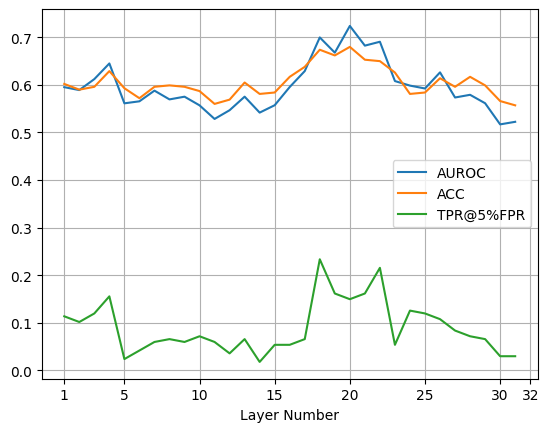

In [3]:
import os
import pickle as pk

import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import auc, roc_curve

# load train and test scores from /data
with open('data/scores_fava_annot_llama_500samp.pkl', 'rb') as f:
    scores, sample_indiv_scores, sample_labels = pk.load(f)
    
def get_roc_auc_scores(scores: np.array, labels: np.array):
    """
    Calculate ROC AUC metrics, including the AUC score, accuracy, and other key values.

    Args:
        scores (np.array): Predicted scores.
        labels (np.array): Ground Truth binary labels.

    Returns:
        tuple: A tuple containing the following:
            - arc (float): Area Under the Curve (AUC) for the Receiver Operating Characteristic (ROC) curve.
            - acc (float): Maximum accuracy derived from the ROC curve.
            - low (float): True Positive Rate (TPR) at the maximum False Positive Rate (FPR) < 0.05.
            - fpr (np.ndarray): False Positive Rates at various thresholds.
            - tpr (np.ndarray): True Positive Rates at various thresholds.
            - thresh_ind (int): Index of the threshold corresponding to maximum accuracy.
            - thresh (np.ndarray): Thresholds used for calculating the ROC curve.
    """
    fpr, tpr, thresh = roc_curve(labels, scores)
    arc = auc(fpr, tpr)
    acc = np.max(1 - (fpr + (1 - tpr))/2)
    thresh_ind = np.argmax(1 - (fpr + (1 - tpr))/2)
    low = tpr[np.where(fpr<0.05)[0][-1]]
    return arc, acc, low, fpr, tpr, thresh_ind, thresh


def get_thresh_val(thresh: np.array, acc: float, scores: np.array):
    """Find approx threshold that matches avg accuracy"""
    for t in thresh:
        pred_list = np.array([ 1 if x < t else 0 for x in scores])
        if np.mean(pred_list) <= acc:
            #print(f"Accuracy: {acc:.2f} , {np.mean(pred_list):.2f}")
            return t, pred_list

def get_balanced_scores(scores: np.array, sample_labels: np.array):
    """Get balanced scores"""
    num_samp = min(sum(sample_labels), len(sample_labels)-sum(sample_labels))
    bal_sc = np.concatenate([scores[:num_samp] , scores[-num_samp:]])
    bal_labels = np.concatenate([sample_labels[:num_samp], sample_labels[-num_samp:]])
    return bal_sc, bal_labels

ly_scores = -np.array(sample_indiv_scores['logit']["perplexity"])
arc, acc, low, fpr, tpr, thresh_ind, thresh = get_roc_auc_scores(*get_balanced_scores(ly_scores,sample_labels))
# print(f"AUROC:{arc*100:.2f}, Acc:{acc*100:.2f}, TPR@5%FPR:{low*100:.2f}")
print(f"PPL & {arc*100:.2f} & {acc*100:.2f} & {low*100:.2f} \\\\")

ly_scores = np.array(sample_indiv_scores['logit']["window_entropy"])
arc, acc, low, fpr, tpr, thresh_ind, thresh = get_roc_auc_scores(*get_balanced_scores(ly_scores,sample_labels))
print(f"Window Entropy & {arc*100:.2f} & {acc*100:.2f} & {low*100:.2f} \\\\")

ly_scores = np.array(sample_indiv_scores['logit']["logit_entropy"])
arc, acc, low, fpr, tpr, thresh_ind, thresh = get_roc_auc_scores(*get_balanced_scores(ly_scores,sample_labels))
print(f"Logit Entropy & {arc*100:.2f} & {acc*100:.2f} & {low*100:.2f} \\\\")

num_layers = len(sample_indiv_scores['attns'].keys())  # The 7B and 8B models that are being evaluated have 32 layers, so num_layers=31
arc_list, acc_list, low_list = [], [], []

samp_preds = []
thresh_vals = []

for layer_num in range(1, num_layers + 1):
    scores = -np.array(sample_indiv_scores['attns']["Attn"+str(layer_num)])
    bal_sc, bal_labels = get_balanced_scores(scores,sample_labels)
    arc, acc, low, fpr, tpr, thresh_ind, thresh = get_roc_auc_scores(bal_sc,bal_labels)
    thresh_val, pred_list = get_thresh_val(thresh, acc, bal_sc)
    samp_preds.append(pred_list)
    thresh_vals.append(thresh_val)
    print(f"Layer:{layer_num+1} - AUROC:{arc:.4f}, Acc:{acc:.4f}, TPR@5%FPR:{low:.4f}")
    arc_list.append(arc)
    acc_list.append(acc)
    low_list.append(low)
    plt.plot(fpr, tpr, label = f'LY{layer_num}, AUC={arc*100:.2f}, Acc={acc*100:.2f}, TPR@5%FPR={low*100:.2f}') 


plt.clf()
plt.xticks([1, 5, 10, 15, 20, 25, 30, 32])
plt.plot(range(1, len(arc_list) + 1), arc_list, label='AUROC')
plt.plot(range(1, len(arc_list) + 1), acc_list, label='ACC')
plt.plot(range(1, len(arc_list) + 1), low_list, label='TPR@5%FPR')
plt.xlabel('Layer Number')
plt.grid()
plt.legend()
plt.savefig("plots/llama_hidden_fava.png", dpi=200, bbox_inches='tight')
plt.show()


PPL & 57.81 & 62.50 & 0.00 \\
Window Entropy & 54.75 & 57.50 & 10.00 \\
Logit Entropy & 54.94 & 60.00 & 10.00 \\


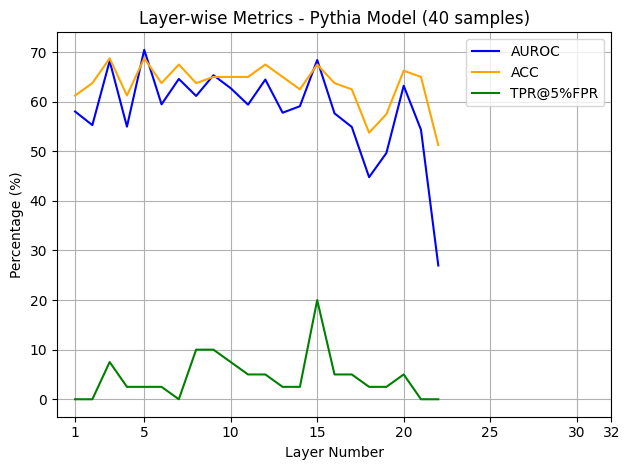

In [8]:
# Load train and test scores from /data
with open('data/scores_fava_annot_pythia_40samp.pkl', 'rb') as f:
    scores, sample_indiv_scores, sample_labels = pk.load(f)
    
ly_scores = -np.array(sample_indiv_scores['logit']["perplexity"])
arc, acc, low, fpr, tpr, thresh_ind, thresh = get_roc_auc_scores(*get_balanced_scores(ly_scores, sample_labels))
print(f"PPL & {arc*100:.2f} & {acc*100:.2f} & {low*100:.2f} \\\\")

ly_scores = np.array(sample_indiv_scores['logit']["window_entropy"])
arc, acc, low, fpr, tpr, thresh_ind, thresh = get_roc_auc_scores(*get_balanced_scores(ly_scores, sample_labels))
print(f"Window Entropy & {arc*100:.2f} & {acc*100:.2f} & {low*100:.2f} \\\\")

ly_scores = np.array(sample_indiv_scores['logit']["logit_entropy"])
arc, acc, low, fpr, tpr, thresh_ind, thresh = get_roc_auc_scores(*get_balanced_scores(ly_scores, sample_labels))
print(f"Logit Entropy & {arc*100:.2f} & {acc*100:.2f} & {low*100:.2f} \\\\")


# Layer indices
layer_indices = range(1, len(arc_list) + 1)

# Plot metrics vs layer number
plt.plot(layer_indices, [x * 100 for x in arc_list], label='AUROC', color='blue')
plt.plot(layer_indices, [x * 100 for x in acc_list], label='ACC', color='orange')
plt.plot(layer_indices, [x * 100 for x in low_list], label='TPR@5%FPR', color='green')

plt.xlabel('Layer Number')
plt.ylabel('Percentage (%)')
plt.xticks([1, 5, 10, 15, 20, 25, 30, 32])
plt.grid(True)
plt.legend()
plt.title("Layer-wise Metrics - Pythia Model (40 samples)")
plt.tight_layout()

# Save plot
plt.savefig("plots/pythia_hidden_fava.png", dpi=200, bbox_inches='tight')
plt.show()

# Conclusion and Future Direction


LLM-Check outperformed many baselines, especially when using Attention Scores. For example:

•	On FAVA (with no external data), LLM-Check achieved significantly higher detection accuracy, even when other methods failed.

•	On SelfCheckGPT, despite not using multiple generations, LLM-Check’s Attention Score beat SelfCheckGPT in several metrics like accuracy and true positive rate.

•	On RAGTruth (with external documents), LLM-Check continued to perform strongly—especially when using Hidden Scores in white-box and Attention Scores in black-box settings.

It also proved to be lightning-fast. Methods like INSIDE or SelfCheckGPT can take tens of seconds to analyze a single response. LLM-Check does the job in fractions of a second (0.22s for Attention Score, 2.72s for Hidden Score). That’s a game-changer for real-time systems.



We can acknowledge some <b>limitations</b>:

1.	We assume access to at least one open-source LLM (like LLaMA) for running detection. If you only have access to a closed-source API (like ChatGPT with no internals), you may not get the same results.

2.	This method detects, but does not mitigate hallucinations. However, it could be used during training to reduce hallucinations by filtering out poor outputs.

3.	Combining all signals (hidden, attention, perplexity, entropy) into a unified classifier is complex. They tried basic logistic regression but didn’t see big gains. Future work might train better detectors that learn how to combine these scores optimally.


LLM-Check is not just another paper on hallucination detection. It’s a practical, scalable, and accurate system for the real world. It doesn’t need external data or slow operations. It doesn’t need model retraining. And it works even when you only have one model response and limited access to the model’s internals.

If you’re building a tool that depends on LLM outputs, LLM-Check can be integrated as a fast filter—flagging potentially hallucinated answers and prompting a second look, a new generation, or a fact-check.





# References:

[1]: Manakul, P., Yao, J., Neubig, G., & Cohn, T. "SelfCheckGPT: Zero-resource Black-box Hallucination Detection for Generative Large Language Models", ACL 2023, pp. 4351–4370.

[2]: Chen, S., Tang, Y., Du, Y., Yao, J., Neubig, G., & Cohn, T. "INSIDE: Interpretable Self-consistency Decoding for Hallucination Detection", ICLR 2024.

[3]: Azaria, A., & Mitchell, T. "Detecting Hallucinated Content in Generative Language Models Using Internal Representations", NeurIPS 2023.

[4]: Wu, T., Yang, J., Sun, Y., Liu, Y., & He, P. "RAGTruth: Evaluating and Mitigating Hallucination in Retrieval-Augmented Generation", arXiv preprint arXiv:2310.02226, 2023.

[5]: Mishra, S., Lin, J., & Xiong, C. "FAVA: A Fine-Grained Benchmark for Hallucination Detection in Large Language Models", ACL 2024 (to appear).

[6]: Yuksekgonul, M., Chandrasekaran, V., Jones, E., Gunasekar, S., Naik, R., Palangi, H., Kamar, E., & Nushi, B. "Attention Satisfies: A Constraint-Satisfaction Lens on Factual Errors of Language Models", ICLR, 2024.

[7]: Wang, X., Wei, J., Schuurmans, D., Le, Q., Chi, E., Narang, S., Chowdhery, A., & Zhou, D. "Self-Consistency Improves Chain of Thought Reasoning in Language Models", arXiv preprint arXiv:2203.11171, 2023.

[8]: Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, Ł., & Polosukhin, I. "Attention is All You Need", NeurIPS, Vol. 30, 2017, pp. 5998–6008.

[9]: Kadavath, S., Conerly, T., Goldie, A., Lyzhov, A., Jacob, A., Song, H., Tandon, S., Wallace, E., & Askell, A. "Language Models 'Know' When They’re Lying", arXiv preprint arXiv:2207.05221, 2022.
